# **Mono-Dimensional**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Vittorio Haardt, Luca Porcelli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Extraction Train

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vittoriohaardt","key":"0597660d0f3cc554b6aff002bf5285bc"}'}

In [ ]:
#Create a kaggle directory and store your Kaggle.json file inside it
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
! kaggle datasets download -d uldisvalainis/audio-emotions

 99% 1.11G/1.12G [00:23<00:00, 64.8MB/s]
100% 1.12G/1.12G [00:23<00:00, 50.5MB/s]


In [ ]:
!unzip "/content/audio-emotions.zip" -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/Emotions/Happy/OAF_keg_happy.wav  
  inflating: Data/Emotions/Happy/OAF_kick_happy.wav  
  inflating: Data/Emotions/Happy/OAF_kill_happy.wav  
  inflating: Data/Emotions/Happy/OAF_king_happy.wav  
  inflating: Data/Emotions/Happy/OAF_kite_happy.wav  
  inflating: Data/Emotions/Happy/OAF_knock_happy.wav  
  inflating: Data/Emotions/Happy/OAF_late_happy.wav  
  inflating: Data/Emotions/Happy/OAF_laud_happy.wav  
  inflating: Data/Emotions/Happy/OAF_lean_happy.wav  
  inflating: Data/Emotions/Happy/OAF_learn_happy.wav  
  inflating: Data/Emotions/Happy/OAF_lease_happy.wav  
  inflating: Data/Emotions/Happy/OAF_lid_happy.wav  
  inflating: Data/Emotions/Happy/OAF_life_happy.wav  
  inflating: Data/Emotions/Happy/OAF_limb_happy.wav  
  inflating: Data/Emotions/Happy/OAF_live_happy.wav  
  inflating: Data/Emotions/Happy/OAF_loaf_happy.wav  
  inflating: Data/Emotions/Happy/OAF_long_happy.wav  
  inflating: Data/Emotions/Hap

# Installing packages and loading libraries

In [ ]:
pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
pip install PySoundFile

In [ ]:
from scipy.io import wavfile as wav
import IPython.display as ipd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from time import time
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
import wave
import matplotlib.pyplot as plt
import random
import shutil
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Reshape, BatchNormalization, Dropout
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from keras.layers import InputLayer, Conv1D, MaxPooling1D
from boruta import BorutaPy
import joblib
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Dataset balancing

In [ ]:
# Set the seed for reproducibility
seed_value = 777
random.seed(seed_value)

# Path to the main folder
main_folder = "/content/Data/Emotions"

# Create a new folder for the selected files
new_folder = "/content/Data/Emotions_New"
os.makedirs(new_folder, exist_ok=True)

# Dictionary to track the distribution of file quantities in the old subfolders
old_folder_distribution = {}

# Find the subfolder with the fewest files
min_num_files = float('inf')

# Iterate through the sorted subfolders
for emotion in sorted(os.listdir(main_folder)):
    emotion_subfolder = os.path.join(main_folder, emotion)

    # Sort the list of files in the subfolder
    file_list = sorted(os.listdir(emotion_subfolder))

    num_files = len(file_list)
    old_folder_distribution[emotion] = num_files

    if num_files < min_num_files:
        min_num_files = num_files

# Dictionary to track the distribution of file quantities in the new subfolders
new_folder_distribution = {}

# Iterate through the sorted subfolders
for emotion in sorted(os.listdir(main_folder)):
    emotion_subfolder = os.path.join(main_folder, emotion)

    # Sort the list of files in the subfolder
    file_list = sorted(os.listdir(emotion_subfolder))

    # Randomly select 'min_num_files' files from the current subfolder
    selected_files = random.sample(file_list, min_num_files)

    # Create a new subfolder in the destination folder
    new_subfolder = os.path.join(new_folder, emotion)
    os.makedirs(new_subfolder, exist_ok=True)

    new_folder_distribution[emotion] = min_num_files

    # Copy the selected files to the new subfolder
    for file in selected_files:
        source_file = os.path.join(emotion_subfolder, file)
        destination_file = os.path.join(new_subfolder, file)
        shutil.copyfile(source_file, destination_file)

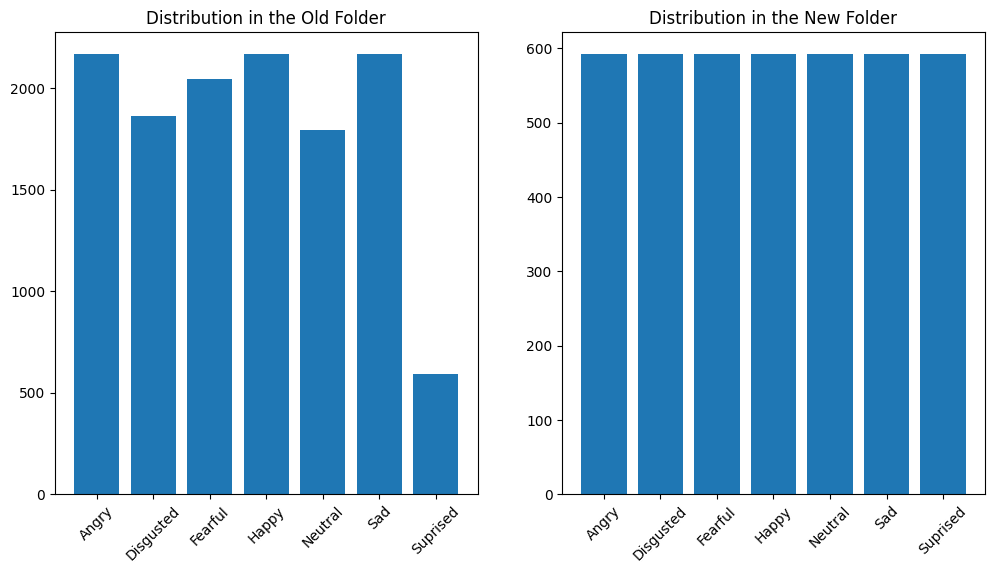

In [ ]:
# Bar chart creation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for the distribution in the old folder
ax1.bar(old_folder_distribution.keys(), old_folder_distribution.values())
ax1.set_title('Distribution in the Old Folder')

# Bar chart for the distribution in the new folder
ax2.bar(new_folder_distribution.keys(), new_folder_distribution.values())
ax2.set_title('Distribution in the New Folder')

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Show the chart
plt.show()

In [ ]:
# Import file
sound_rate, sound_data = wav.read('/content/Data/Emotions_New/Angry/1013_IWL_ANG_XX.wav')
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

# Exploring the Distribution of Samples

In [ ]:
# Path to the folder containing subfolders for each emotion
base_folder_path = '/content/Data/Emotions_New/'

# List to store audio data lengths
all_sound_data_lengths = []

# Iterate through the subfolders
for emotion_folder in os.listdir(base_folder_path):
    emotion_folder_path = os.path.join(base_folder_path, emotion_folder)

    # Ensure the path is a folder
    if os.path.isdir(emotion_folder_path):
        # Iterate through the audio files in the subfolder
        for file_name in os.listdir(emotion_folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(emotion_folder_path, file_name)

                signal, _ = librosa.load(file_path, sr=48000)
                all_sound_data_lengths.append(len(signal))
# Calculate quartiles and average of the audio data lengths
if all_sound_data_lengths:
    quartiles = np.percentile(all_sound_data_lengths, [0, 25, 50, 75, 100])
    average_sound_data_length = np.mean(all_sound_data_lengths)
    print(f"Minimum: {quartiles[0]} samples")
    print(f"First quartile: {quartiles[1]} samples")
    print(f"Median: {quartiles[2]} samples")
    print(f"Third quartile: {quartiles[3]} samples")
    print(f"Maximum: {quartiles[4]} samples")
    print(f"Average: {average_sound_data_length} samples")
else:
    print("No audio files found.")

Minimum: 60861.0 samples
First quartile: 99834.25 samples
Median: 118518.0 samples
Third quartile: 150951.0 samples
Maximum: 336605.0 samples
Average: 129235.83204633204 samples


# Data loader

In [ ]:
# Placeholder for feature extractor
def identity(input):
    return input

# Function to check if a file is in WAV format
def is_wav_file(file_path):
    try:
        librosa.load(file_path, sr=None)
        return True
    except Exception as e:
        print(f"Errore durante il controllo del file {file_path}: {e}")
        return False

# Data loader
def load_data(data_folder, feature_extractor=identity, length=int(average_sound_data_length), normalize=False):

    labels = []
    features = []

    for label in tqdm(os.listdir(data_folder)):
        label_folder = os.path.join(data_folder, label)
        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.wav') and is_wav_file(os.path.join(label_folder, file_name)):
                    file_path = os.path.join(label_folder, file_name)

                    # Load file and compute the requested features
                    signal, _ = librosa.load(file_path, sr=48000)

                    # Adjust the length of the signal to the desired length
                    if len(signal) < length:
                        # Pad the signal with zeros if it's shorter than the desired length
                        signal = np.pad(signal, (0, length - len(signal)))
                    elif len(signal) > length:
                        # Trim the signal if it's longer than the desired length
                        signal = signal[:length]

                    cur_features = feature_extractor(signal)
                    features.append(cur_features)

                    # Classes
                    labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps) / (X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps) / (X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Low-level audio classification

## RMS - Spectral centroid - Bandwidth - ZCR - Spectral-roll off - Spectrum Magnitude - Energy

In [ ]:
def combo(input):
    rms = np.sqrt(np.mean(input**2))  # Root Mean Square (RMS) level
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=input, n_fft=100))  # Spectral centroid
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=input, n_fft=100))  # Bandwidth
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(input)[0])  # Zero-crossing rate
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=input, n_fft=100))  # Spectral-roll off
    spectrum_magnitude = np.mean(np.abs(librosa.core.magphase(librosa.stft(input))[0])) # Spectrum magnitude
    energy = np.sum((input*1.0)**2, keepdims=True)[0] # Energy

    # Concatenate all features into a single array
    return np.array([rms, spectral_centroid, bandwidth, zero_crossing_rate, spectral_rolloff, spectrum_magnitude, energy])

In [ ]:
X_train, X_test, y_train, y_test = load_data('/content/Data/Emotions_New',feature_extractor=combo, normalize=True)

100%|██████████| 7/7 [02:11<00:00, 18.73s/it]


## Boruta Feature Selection

In [ ]:
# Create a Random Forest Classifier with 100 estimators and a fixed random state
model = RandomForestClassifier(n_estimators=100, random_state=777)

# Initialize Boruta feature selector
boruta_selector = BorutaPy(model, n_estimators='auto', random_state=777)

# Run Boruta on your training set
boruta_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(n_estimators=37,
                                          random_state=RandomState(MT19937) at 0x7B3E5A6E1D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B3E5A6E1D40)

In [ ]:
# Convert the list of arrays to a single NumPy array
feature_names = np.array(X_train)
# Extract selected features using the indices of the columns identified by Boruta
selected_features = feature_names[:, boruta_selector.support_].tolist()

X_train=selected_features

In [ ]:
# Convert the list of arrays to a single NumPy array
feature_names_test = np.array(X_test)
# Extract selected features using the indices of the columns identified by Boruta
selected_features_test = feature_names_test[:, boruta_selector.support_].tolist()

X_test=selected_features_test

### Models

In [ ]:
# Define models and their respective parameter grids
models = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10], 'p': [1, 2]}),
    'Support Vector Machine': (SVC(kernel='rbf', class_weight='balanced'), {'C': [100, 500, 1000], 'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]})
}

# Directory where models will be saved
save_path = "/content/drive/MyDrive/Digital/Models/Mono-Dimensional/"

# Train and evaluate each model
for model_name, (model, param_grid) in models.items():
    clf = GridSearchCV(model, param_grid, cv=10)

    t0 = time()
    clf.fit(X_train, y_train)
    training_time = time() - t0

    # Evaluate the model on the test set
    accuracy = clf.score(X_test, y_test)

    print(f'{model_name}:')
    print(f'  Training Time: {training_time:.3f}s')
    print(f'  Best Parameters: {clf.best_params_}')
    print(f'  Test Accuracy: {accuracy:.3f}\n')

    # Save the model with best parameters to the specified directory
    best_model = clf.best_estimator_
    joblib.dump(best_model, f'{save_path}/{model_name}_best_model.pkl')

Random Forest:
  Training Time: 159.576s
  Best Parameters: {'max_depth': 10, 'n_estimators': 300}
  Test Accuracy: 0.478

K-Nearest Neighbors:
  Training Time: 2.396s
  Best Parameters: {'n_neighbors': 10, 'p': 2}
  Test Accuracy: 0.443

Support Vector Machine:
  Training Time: 211.596s
  Best Parameters: {'C': 1000, 'gamma': 0.1}
  Test Accuracy: 0.502



In [ ]:
# Train SVC model with best parameters
best_svc = SVC(kernel='rbf', class_weight='balanced', C=100, gamma=0.1)
best_svc.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', gamma=0.1)

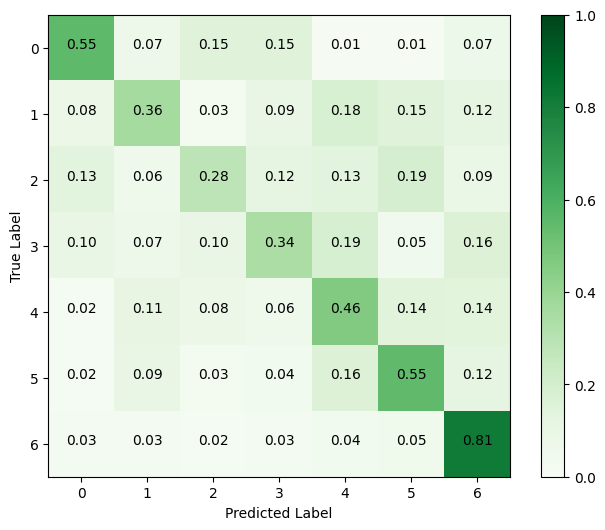

In [ ]:
# Predict labels for test set
y_pred = best_svc.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix with green blocks
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greens)

# Add numbers to the plot
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="black")

# Customize color bar limits
plt.colorbar()
plt.clim(0, 1)  # Setting color bar limits from 0 to 1
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ANN

In [ ]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
# Define a simple neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_array.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_array, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, verbose=2, callbacks=[lr_scheduler, early_stop, best_model])

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_test_encoded, y_pred)

print(f'Neural Network:')
print(f'  Training Time: {training_time:.3f}s')
print(f'  Test Accuracy: {accuracy:.3f}\n')

Epoch 1/1000

Epoch 1: val_loss improved from inf to 1.79833, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5
83/83 - 5s - loss: 1.9114 - accuracy: 0.2161 - val_loss: 1.7983 - val_accuracy: 0.2745 - lr: 0.0010 - 5s/epoch - 66ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.79833 to 1.74458, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5
83/83 - 0s - loss: 1.8327 - accuracy: 0.2738 - val_loss: 1.7446 - val_accuracy: 0.2866 - lr: 0.0010 - 333ms/epoch - 4ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.74458 to 1.70165, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5
83/83 - 0s - loss: 1.7825 - accuracy: 0.2903 - val_loss: 1.7016 - val_accuracy: 0.3394 - lr: 0.0010 - 337ms/epoch - 4ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.70165 to 1.67952, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5
83/83 - 0s - loss: 1.7560 - accuracy: 0.3088 - val_loss: 1.6795 - val_accuracy: 0.3273 - lr: 0.0010 - 305ms/epoch - 4ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.67952 to 1.66432, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_features.h5
83/83 

### DL

In [ ]:
# Convert everything into numpy arrays for subsequent neural processing
X = np.array(X_train)
y = np.array(y_train)
y_t = np.array(y_test)
X_t = np.array(X_test)

# Assuming y_train and y_test are your original string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.transform(y_t)

X = np.expand_dims(X, axis=-1)  # Add channel dimension
X_t = np.expand_dims(X_t, axis=-1)    # Add channel dimension

In [ ]:
input_shape = X[0].shape

input_layer = Input(shape=input_shape)
x = Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(64, 2, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)

x = Flatten(data_format='channels_last')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_features.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/1000
83/83 [==============================] - ETA: 0s - loss: 3.4972 - accuracy: 0.1486
Epoch 1: val_loss improved from inf to 3.03045, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_features.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 6s 17ms/step - loss: 3.4972 - accuracy: 0.1486 - val_loss: 3.0305 - val_accuracy: 0.1448 - lr: 1.0000e-04
Epoch 2/1000
80/83 [===========================>..] - ETA: 0s - loss: 3.2263 - accuracy: 0.1816
Epoch 2: val_loss improved from 3.03045 to 3.00374, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_features.h5
83/83 [==============================] - 1s 9ms/step - loss: 3.2271 - accuracy: 0.1821 - val_loss: 3.0037 - val_accuracy: 0.1795 - lr: 1.0000e-04
Epoch 3/1000
79/83 [===========================>..] - ETA: 0s - loss: 3.0981 - accuracy: 0.2021
Epoch 3: val_loss improved from 3.00374 to 2.96374, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_features.h5
83/83 [==============================] - 1s 10ms/step - loss: 3.0864 - accuracy: 0.2085 - val_loss: 2.9637 - val_accuracy: 0.2066 - lr: 1.0000e-04
Epoch 4/1000
82/83 [============================>.] - ETA: 0s - lo

In [ ]:
# Evaluates the model on test data
loss, accuracy = model.evaluate(X_t, y_test_encoded)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

26/26 [==============================] - 0s 6ms/step - loss: 2.0530 - accuracy: 0.4318
Test Loss: 2.0530
Test Accuracy: 0.4318


### Residual Net

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_features.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert data to numpy arrays and add channel dimension
X_train = np.expand_dims(np.array(X_train), axis=-1)
X_test = np.expand_dims(np.array(X_test), axis=-1)

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.MaxPool1D(pool_size=1, strides=1)(x)
    return x


# Model building function
def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv1D(16, 3, activation='relu', padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    output_layer = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

#model = build_model((48000 // 2, 1), 7)
model = build_model((X_train.shape[1], 1), 7)


In [ ]:
# Build and compile the model
model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/1000
83/83 [==============================] - ETA: 0s - loss: 1.9132 - accuracy: 0.2281
Epoch 1: val_loss improved from inf to 1.90423, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_features.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 12s 51ms/step - loss: 1.9132 - accuracy: 0.2281 - val_loss: 1.9042 - val_accuracy: 0.2836 - lr: 1.0000e-04
Epoch 2/1000
83/83 [==============================] - ETA: 0s - loss: 1.8132 - accuracy: 0.2854
Epoch 2: val_loss improved from 1.90423 to 1.83801, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_features.h5
83/83 [==============================] - 1s 16ms/step - loss: 1.8132 - accuracy: 0.2854 - val_loss: 1.8380 - val_accuracy: 0.3122 - lr: 1.0000e-04
Epoch 3/1000
79/83 [===========================>..] - ETA: 0s - loss: 1.7378 - accuracy: 0.3291
Epoch 3: val_loss improved from 1.83801 to 1.78267, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_features.h5
83/83 [==============================] - 1s 16ms/step - loss: 1.7422 - accuracy: 0.3243 - val_loss: 1.7827 - val_accuracy: 0.3273 - lr: 1.0000e-04
Epoch 4/1000
80/83 [===========================>..] - ETA: 0s - loss

In [ ]:
model.evaluate(X_test, y_test_encoded)

26/26 [==============================] - 1s 24ms/step - loss: 1.3906 - accuracy: 0.4548


[1.3906172513961792, 0.45476478338241577]

# MFCC

In [ ]:
#Extracts features from the Mel-Frequency Cepstral Coefficients (MFCC) of an audio signal.
def feats_mfcc(input, rate=48000, tsize=10):
  # Calculate the MFCCs using librosa
  mfcc = librosa.feature.mfcc(y=input * 1.0, sr=rate, n_fft=300, n_mfcc=13)
  # Adjust the size of the MFCCs based on the target size
  if mfcc.shape[1] < tsize:
    pad_width = tsize - mfcc.shape[1]
    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
  elif mfcc.shape[1] > tsize:
    mfcc = mfcc[:, :tsize]
  # Flatten the MFCCs into a one-dimensional array
  output = mfcc.flatten()
  return output

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data('/content/Data/Emotions_New', feature_extractor=feats_mfcc, normalize=True)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 7/7 [00:55<00:00,  7.97s/it]


## Boruta Feature Selection

In [ ]:
# Create a Random Forest Classifier with 100 estimators and a fixed random state
model = RandomForestClassifier(n_estimators=100, random_state=777)

# Initialize Boruta feature selector
boruta_selector = BorutaPy(model, n_estimators='auto', random_state=777)

# Run Boruta on your training set
boruta_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(n_estimators=108,
                                          random_state=RandomState(MT19937) at 0x7B3E5A6E3340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B3E5A6E3340)

In [ ]:
# Convert the list of arrays to a single NumPy array
feature_names = np.array(X_train)
# Extract selected features using the indices of the columns identified by Boruta
selected_features = feature_names[:, boruta_selector.support_].tolist()

In [ ]:
# Extract selected features using the indices of the columns identified by Boruta
selected_features_indices = np.where(boruta_selector.support_)[0]

print("Selected features indices:", selected_features_indices)

Selected features indices: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  35  36  37  38  39  49  56
  57  84  85  86  87  88  89  95 105 106 107 111 112]


In [ ]:
len(X_train[0])

130

In [ ]:
len(selected_features[0])

49

From the result obtained we show the remaining features and in particular we changed from 130 to 49

In [ ]:
X_train=selected_features

In [ ]:
# Convert the list of arrays to a single NumPy array
feature_names_test = np.array(X_test)

# Extract selected features using the indices of the columns identified by Boruta
selected_features_test = feature_names_test[:, boruta_selector.support_].tolist()


In [ ]:
X_test=selected_features_test

### Models

In [ ]:
# Define models and their respective parameter grids
models = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10], 'p': [1, 2]}),
    'Support Vector Machine': (SVC(kernel='rbf', class_weight='balanced'), {'C': [100, 500, 1000], 'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]})
}

# Directory where models will be saved
save_path = "/content/drive/MyDrive/Digital/Models/Mono-Dimensional/"

# Train and evaluate each model
for model_name, (model, param_grid) in models.items():
    clf = GridSearchCV(model, param_grid, cv=10)

    t0 = time()
    clf.fit(X_train, y_train)
    training_time = time() - t0

    # Evaluate the model on the test set
    accuracy = clf.score(X_test, y_test)

    print(f'{model_name}:')
    print(f'  Training Time: {training_time:.3f}s')
    print(f'  Best Parameters: {clf.best_params_}')
    print(f'  Test Accuracy: {accuracy:.3f}\n')

    # Save the model with best parameters to the specified directory
    best_model = clf.best_estimator_
    joblib.dump(best_model, f'{save_path}/{model_name}_best_model_mfcc.pkl')

Random Forest:
  Training Time: 392.825s
  Best Parameters: {'max_depth': 10, 'n_estimators': 200}
  Test Accuracy: 0.444

K-Nearest Neighbors:
  Training Time: 5.705s
  Best Parameters: {'n_neighbors': 10, 'p': 1}
  Test Accuracy: 0.402

Support Vector Machine:
  Training Time: 398.711s
  Best Parameters: {'C': 100, 'gamma': 0.01}
  Test Accuracy: 0.435



In [ ]:
# Define models and their respective parameter grids
models = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 10], 'p': [1, 2]}),
    'Support Vector Machine': (SVC(kernel='rbf', class_weight='balanced'), {'C': [100, 500, 1000], 'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]})
}

# Train and evaluate each model
for model_name, (model, param_grid) in models.items():
    clf = GridSearchCV(model, param_grid, cv=10)

    t0 = time()
    clf.fit(X_train, y_train)
    training_time = time() - t0

    # Evaluate the model on the test set
    accuracy = clf.score(X_test, y_test)

    print(f'{model_name}:')
    print(f'  Training Time: {training_time:.3f}s')
    print(f'  Best Parameters: {clf.best_params_}')
    print(f'  Test Accuracy: {accuracy:.3f}\n')

Random Forest:
  Training Time: 34.921s
  Best Parameters: {'max_depth': 10, 'n_estimators': 100}
  Test Accuracy: 0.450

K-Nearest Neighbors:
  Training Time: 4.328s
  Best Parameters: {'n_neighbors': 10, 'p': 1}
  Test Accuracy: 0.422

Support Vector Machine:
  Training Time: 30.110s
  Best Parameters: {'C': 100, 'gamma': 0.005}
  Test Accuracy: 0.462



### ANN

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_mfcc.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

In [ ]:
# Encode class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define a simple neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_array.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_array, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, verbose=2, callbacks=[lr_scheduler, early_stop, best_model])

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probabilities, axis=1)

accuracy = accuracy_score(y_test_encoded, y_pred)

print(f'Neural Network:')
print(f'  Training Time: {training_time:.3f}s')
print(f'  Test Accuracy: {accuracy:.3f}\n')

Epoch 1/1000

Epoch 1: val_loss improved from inf to 1.74032, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_mfcc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 - 2s - loss: 1.9412 - accuracy: 0.2236 - val_loss: 1.7403 - val_accuracy: 0.2986 - lr: 0.0010 - 2s/epoch - 25ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 1.74032 to 1.71979, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_mfcc.h5
83/83 - 0s - loss: 1.8104 - accuracy: 0.2681 - val_loss: 1.7198 - val_accuracy: 0.3167 - lr: 0.0010 - 318ms/epoch - 4ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.71979 to 1.67561, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_mfcc.h5
83/83 - 0s - loss: 1.7524 - accuracy: 0.3005 - val_loss: 1.6756 - val_accuracy: 0.3152 - lr: 0.0010 - 297ms/epoch - 4ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.67561 to 1.65977, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_ANN_mfcc.h5
83/83 - 0s - loss: 1.7397 - accuracy: 0.2926 - val_loss: 1.6598 - val_accuracy: 0.3318 - lr: 0.0010 - 300ms/epoch - 4ms/step
Epoch 5/1000

Epoch 5: val_loss improved

### DL

In [ ]:
# Convert everything into numpy arrays for subsequent neural processing
X = np.array(X_train)
y = np.array(y_train)
y_t = np.array(y_test)
X_t = np.array(X_test)

# Assuming y_train and y_test are your original string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.transform(y_t)

X = np.expand_dims(X, axis=-1)  # Add channel dimension
X_t = np.expand_dims(X_t, axis=-1)    # Add channel dimension

In [ ]:
input_shape = X[0].shape

input_layer = Input(shape=input_shape)

x = Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Flatten(data_format='channels_last')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_mfcc.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/1000
83/83 [==============================] - ETA: 0s - loss: 4.2345 - accuracy: 0.2040
Epoch 1: val_loss improved from inf to 3.48821, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_mfcc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 4s 22ms/step - loss: 4.2345 - accuracy: 0.2040 - val_loss: 3.4882 - val_accuracy: 0.1765 - lr: 1.0000e-04
Epoch 2/1000
81/83 [============================>.] - ETA: 0s - loss: 3.5551 - accuracy: 0.2604
Epoch 2: val_loss improved from 3.48821 to 3.42087, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_mfcc.h5
83/83 [==============================] - 1s 7ms/step - loss: 3.5534 - accuracy: 0.2590 - val_loss: 3.4209 - val_accuracy: 0.2443 - lr: 1.0000e-04
Epoch 3/1000
79/83 [===========================>..] - ETA: 0s - loss: 3.3879 - accuracy: 0.2844
Epoch 3: val_loss improved from 3.42087 to 3.33460, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_conv_mfcc.h5
83/83 [==============================] - 1s 7ms/step - loss: 3.3917 - accuracy: 0.2809 - val_loss: 3.3346 - val_accuracy: 0.2730 - lr: 1.0000e-04
Epoch 4/1000
80/83 [===========================>..] - ETA: 0s - loss: 3.308

In [ ]:
# Evaluates the model on test data
loss, accuracy = model.evaluate(X_t, y_test_encoded)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

26/26 [==============================] - 0s 6ms/step - loss: 2.1992 - accuracy: 0.4367
Test Loss: 2.1992
Test Accuracy: 0.4367


### Residual Net

In [ ]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert data to numpy arrays and add channel dimension
X_train = np.expand_dims(np.array(X_train), axis=-1)
X_test = np.expand_dims(np.array(X_test), axis=-1)

In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 10 and if the epoch is not zero
    if (epoch % 10 == 0) and (epoch != 0):
        # Reduce the learning rate by 20%
        lr = lr * 0.8
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',               # Monitors validation loss
    patience=20,                      # Number of epochs with no improvement before stopping
    verbose=1,                        # Prints messages about early stopping
    restore_best_weights=True         # Restores model weights from the epoch with the best value of the monitored quantity
)

checkpoint_filepath = '/content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_mfcc.h5'
best_model = ModelCheckpoint(checkpoint_filepath,
                             verbose=1,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False)

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.MaxPool1D(pool_size=1, strides=1)(x)
    return x


# Model building function
def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv1D(16, 3, activation='relu', padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    output_layer = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

model = build_model((X_train.shape[1], 1), 7)

In [ ]:
# Build and compile the model
model = build_model((X_train.shape[1], 1), len(np.unique(y_train_encoded)))
model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler, early_stop, best_model])

Epoch 1/1000
83/83 [==============================] - ETA: 0s - loss: 1.8113 - accuracy: 0.2907
Epoch 1: val_loss improved from inf to 1.81958, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_mfcc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 12s 53ms/step - loss: 1.8113 - accuracy: 0.2907 - val_loss: 1.8196 - val_accuracy: 0.3077 - lr: 1.0000e-04
Epoch 2/1000
79/83 [===========================>..] - ETA: 0s - loss: 1.6536 - accuracy: 0.3441
Epoch 2: val_loss improved from 1.81958 to 1.73042, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_mfcc.h5
83/83 [==============================] - 1s 16ms/step - loss: 1.6506 - accuracy: 0.3465 - val_loss: 1.7304 - val_accuracy: 0.3514 - lr: 1.0000e-04
Epoch 3/1000
81/83 [============================>.] - ETA: 0s - loss: 1.5995 - accuracy: 0.3723
Epoch 3: val_loss improved from 1.73042 to 1.65078, saving model to /content/drive/MyDrive/Digital/Models/Mono-Dimensional/best_model_RB_mfcc.h5
83/83 [==============================] - 1s 16ms/step - loss: 1.5999 - accuracy: 0.3725 - val_loss: 1.6508 - val_accuracy: 0.3529 - lr: 1.0000e-04
Epoch 4/1000
82/83 [============================>.] - ETA: 0s - loss: 1.5733

In [ ]:
model.evaluate(X_test, y_test_encoded)

26/26 [==============================] - 1s 20ms/step - loss: 1.4195 - accuracy: 0.4306


[1.4194854497909546, 0.4306393265724182]